In [1]:
import cv2
import numpy as np
import os 
from matplotlib import pyplot as plt
import time 
import mediapipe as mp

# 2.KEYPOINTS USING MP HOLISTIC


In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False # IMAGE IS NO LONGER WRITEABLE
    results = model.process(image) # MAKE PRIDICTION
    image.flags.writeable = True # IMAGE IS NOW WRITEABLE
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) # COLOR CONVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.roght_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_styled_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.Drawingspec(color=(80,110,10),thickness = 1, circle_radius=1),
                              mp_drawing.Drawingspec(color=(80,256,121),thickness=1,circle_radius=1)
                              )
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.Drawingspec(color=(80,22,10),thickness = 2, circle_radius=4),
                              mp_drawing.Drawingspec(color=(80,44,121),thickness=2,circle_radius=2)
                              )
                             
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.Drawingspec(color=(121,22,76),thickness =2, circle_radius=4),
                              mp_drawing.Drawingspec(color=(121,44,250),thickness=2,circle_radius=2)
                              )
    mp_drawing.draw_landmarks(image,results.roght_hand_landmarks,mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.Drawingspec(color=(245,117,66),thickness = 2, circle_radius=4),
                              mp_drawing.Drawingspec(color=(245,66,230),thickness=2,circle_radius=2)
                              )

In [6]:
mp_drawing.DrawingSpec

mediapipe.python.solutions.drawing_utils.DrawingSpec

In [7]:
cap = cv2.VideoCapture(0)
# SET MEDIAPIPE MODEL
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # MAKE DETECTIONS 
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        draw_styled_landmarks(image, results)
         
        cv2.imshow('Opencv Feed', image)
    
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

    

<class 'mediapipe.python.solution_base.SolutionOutputs'>


AttributeError: module 'mediapipe.python.solutions.drawing_utils' has no attribute 'Drawingspec'

In [ ]:
draw_landmarks(frame,results)

AttributeError: type object 'SolutionOutputs' has no attribute 'roght_hand_landmarks'

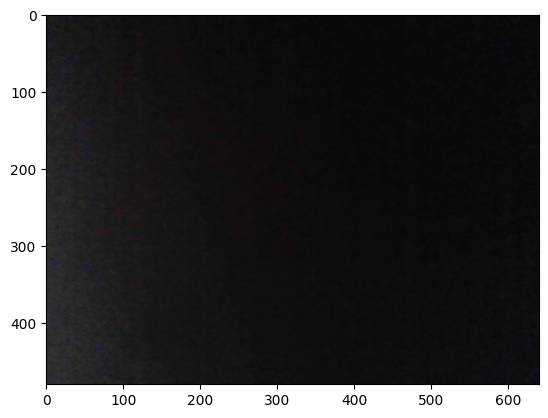

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# EXTRACRTION KEYPOINTS VALUES


In [ ]:
results.pose_landmarks.landmark[0].visibility


AttributeError: 'NoneType' object has no attribute 'landmark'

In [ ]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [ ]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z, res.visibility] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [ ]:
face= np.array([[res.x, res.y, res.z, res.visibility] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)